In [78]:
!pip install evaluate
!pip install seqeval
!pip install wandb
!pip install optimum
!pip install onnx onnxruntime
!pip install bentoml

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Practice 8

Note: Most of the code reffering training the original pretrained model was taken from `practice5.ipynb`

In [79]:
import os
import string
from typing import List
import warnings
import numpy as np
import pandas as pd
from itertools import chain
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import nltk
import spacy
import re
from tqdm import tqdm

from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier

import torch
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification

%matplotlib inline

<a id='Token_classification_with_Transformers'></a>
# Token classification with Transformers

In [80]:
import pandas as pd

df_locations_ua = pd.read_csv('/kaggle/input/mantis-analytics-location-detection/uk_geo_dataset.csv')
df_locations_ru = pd.read_csv('/kaggle/input/mantis-analytics-location-detection/ru_geo_dataset.csv')

df_locations_ru = df_locations_ru.sample(frac=0.001)
df_locations_ua = df_locations_ua.sample(frac=0.01)

# Uncomment if high model perfomance is prefered 
# df_locations_ru = df_locations_ru.sample(frac=0.005)
# df_locations_ua = df_locations_ua.sample(frac=0.05)


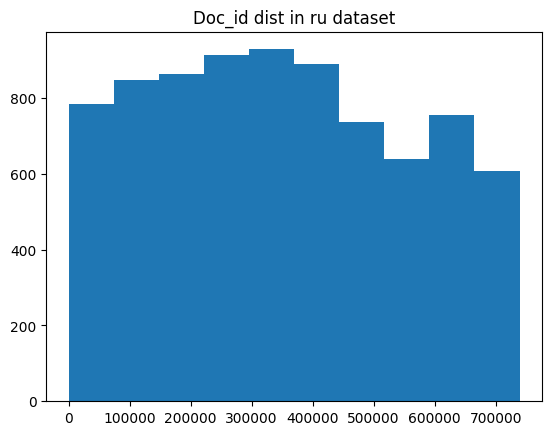

In [81]:
plt.title("Doc_id dist in ru dataset")
plt.hist(dict(df_locations_ru['doc_id'].value_counts()))
plt.show()

In [82]:
df_locations_ru['is_valid'] = 0  # Initialize 'is_valid' to 0 for all rows
df_locations_ru.loc[df_locations_ru['doc_id'] >= 700000, 'is_valid'] = 1

In [83]:
len(df_locations_ru[df_locations_ru['is_valid'] == 0]), len(df_locations_ru[df_locations_ru['is_valid'] == 1])

(7723, 306)

In [84]:
df_locations_ru.drop(['doc_id', 'sent_id'], axis=1,inplace=True)

In [85]:
df_locations_ru

,text,loc_markers,org_markers,per_markers,is_valid
97414,"Великобритания, Нидерланды и ряд других европе...","[(0, 14), (16, 26), (81, 91), (164, 170), (173...",[],[],0
6390323,"38-й президент США Джеральд Форд, скончавшийся...","[(15, 18), (128, 140), (147, 154)]",[],"[(19, 32)]",0
4945174,"Проводя предварительное расследование, полицей...",[],[],"[(83, 90), (93, 100)]",0
415069,Однако у позвоночных животных существуют амило...,[],[],[],0
6855632,"Теперь Владимиру Путину предстоит выбрать, кто...",[],[],"[(7, 23), (117, 135)]",0
...,...,...,...,...,...
7599444,В эфир NHK фильм про Карелина выйдет 14 сентября.,[],"[(7, 10)]","[(21, 29)]",0
4067407,"Помимо Игнатенко, в розыске находится еще один...","[(90, 95)]",[],"[(7, 16), (96, 109)]",0
1654431,"«Потом стало ясно, что это невозможно, а с нач...","[(68, 73)]","[(207, 218)]",[],0
7273236,"Европейское космическое агентство заявило, что...",[],[],[],0


In [86]:
df_locations = pd.concat([df_locations_ru, df_locations_ua])
# df_locations = df_locations_ua
df_locations.sample(10)

,text,loc_markers,org_markers,per_markers,is_valid
1047092,"8 февраля сенатор Джон Маккейн заявил, что опе...","[(79, 82), (85, 91)]","[(75, 78), (127, 135)]","[(18, 30)]",0
407650,Команду вже залишили декілька досвідчених грав...,[],[],[],0
758502,"І міномети», – розповідає журналістам проєкту ...",[],"[(47, 60), (82, 85)]","[(98, 102)]",0
7765670,На территории школы номер 811 Западного округа...,"[(30, 46), (47, 53)]",[],[],1
7372057,Генеральный директор агентства Мохаммед Эль-Ба...,"[(70, 74)]","[(133, 145)]","[(31, 51)]",0
6480329,Kedah Wafer Emas работает на рынке высокотехно...,[],"[(0, 16)]",[],0
995461,"Голдберг на стільки боїться літати, що десь де...",[],[],[],0
443963,"При цьому необхідно визначити довірену особу, ...",[],[],[],0
732967,"До чого це призвело, покажемо на прикладі нижче.",[],[],[],0
716465,"Кращого екологічного індикатора, ніж вона, год...",[],[],[],0


In [87]:
def preprocess_text(text):
    # Remove links
    text = re.sub(r'http\S+|www.\S+', '', text)

    # Special remove telegram links
    pattern = r"(?:https?:\/\/)?(?:www\.)?(?:t\.me\/\S+|telegram\.me\/\S+|telegram\.dog\/\S+)"
    text = re.sub(pattern, '', text)

    # Remove phone numbers
    phone_regex = r'\(?\+?\d{0,3}\)?[-.\s]?\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{2}[-.\s]?\d{2}'
    text = re.sub(phone_regex, '', text)

    # Remove special characters
    text = re.sub(r'[\n\t\r]', ' ', text)

    # Remove tags
    text = re.sub(r'@\w+', '', text)

    # Remove emojis
    emoji_pattern = re.compile(
        pattern="["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)

    # Remove multiple spaces
    text = re.sub(r' +', ' ', text)

    return text

In [88]:
df_locations

,text,loc_markers,org_markers,per_markers,is_valid
97414,"Великобритания, Нидерланды и ряд других европе...","[(0, 14), (16, 26), (81, 91), (164, 170), (173...",[],[],0
6390323,"38-й президент США Джеральд Форд, скончавшийся...","[(15, 18), (128, 140), (147, 154)]",[],"[(19, 32)]",0
4945174,"Проводя предварительное расследование, полицей...",[],[],"[(83, 90), (93, 100)]",0
415069,Однако у позвоночных животных существуют амило...,[],[],[],0
6855632,"Теперь Владимиру Путину предстоит выбрать, кто...",[],[],"[(7, 23), (117, 135)]",0
...,...,...,...,...,...
938854,Не можна тримати квіти голівками донизу або за...,[],[],[],0
266227,"Кожний робот обладнаний камерою, що сканує обл...",[],[],[],0
733798,"Ця карта також розповідає про рух, неперервний...",[],[],[],0
224578,"Яка різниця між експрес, ПЛР- та ІФА-тестами?",[],[],[],0


In [89]:
import spacy

from spacy.training.iob_utils import biluo_to_iob, doc_to_biluo_tags
from tqdm.autonotebook import tqdm
tqdm.pandas()

df_locations.loc_markers = df_locations.loc_markers.apply(lambda x: [[y[0], y[1], 'LOC']  for y in eval(x)])

nlp = spacy.blank("xx")

def convert_to_conll(row):
    data = {
        "text": row['text'],
        "label": row['loc_markers']
    }
    doc = nlp(data["text"])
    ents = []
    for start, end, label in data["label"]:
        span = doc.char_span(start, end, label=label)
        if span is not None:
            ents.append(span)
        else:
            pass
        #TODO fix not align to toke case
        '''
            print(
                "Skipping span (does not align to tokens):",
                start,
                end,
                label,
                doc.text[start:end],
            )
        '''
    doc.ents = ents
    return {
        'tokens': list([t.text for t in doc]),
        'labels': list(biluo_to_iob(doc_to_biluo_tags(doc)))
    }

df_locations['conll'] = df_locations.progress_apply(convert_to_conll, axis=1)

  0%|          | 0/18129 [00:00<?, ?it/s]

In [90]:
label2id = {'O': 0, 'B-LOC': 1, 'I-LOC': 2}

df_locations['tokens'] = df_locations.conll.str['tokens']
df_locations['ner_tags'] = df_locations.conll.str['labels'].apply(lambda x: [label2id[t] for t in x])

df_train = df_locations[df_locations.is_valid == 0]
df_valid = df_locations[df_locations.is_valid == 1]

In [91]:
df_train[['tokens', 'ner_tags']].to_json(
    'train_processed.json', orient='records', lines=True)
df_valid[['tokens', 'ner_tags']].to_json(
    'valid_processed.json', orient='records', lines=True)

In [92]:
from datasets import load_dataset

raw_datasets_ua = load_dataset(
    "json",
    data_files={
        'train': 'train_processed.json',
        'val': 'valid_processed.json'
    }
)
raw_datasets_ua

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-1953eedd07370e7a/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 17729
    })
    val: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 400
    })
})

In [93]:
from transformers import AutoTokenizer, AutoModelForTokenClassification


id2label = {v: k for k, v in label2id.items()}

model = AutoModelForTokenClassification.from_pretrained(
    'bert-base-uncased',
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased'
#                                           , add_prefix_space=True
                                         )

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [94]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)


def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [95]:
tokenized_datasets_ua = raw_datasets_ua.map(
    tokenize_and_align_labels,
    batched=True,
)

  0%|          | 0/18 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [96]:
from transformers import TrainingArguments

args = TrainingArguments(
    "bert-uncased-base",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3
)

In [97]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW([
    {'params': list(model.bert.parameters()), 'lr':  0.000015},
    {'params': list(model.classifier.parameters()), 'lr':  0.0013}
])

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0.1*3*(tokenized_datasets_ua['train'].num_rows/8),
    num_training_steps=3*(tokenized_datasets_ua['train'].num_rows/8)
)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [98]:
import evaluate
import numpy as np

metric = evaluate.load("seqeval")

label_names = list(label2id.keys())

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [99]:
my_api_key = '9d4d0591e05d13690d35330a36ffa0de42a04006'

In [100]:
from transformers import Trainer
import wandb

wandb.login(key=my_api_key)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets_ua["train"],
    eval_dataset=tokenized_datasets_ua["val"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    optimizers=(optimizer, scheduler)
)
trainer.train()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.068800,0.052395,0.544554,0.625000,0.582011,0.984417
2,0.052000,0.041878,0.573991,0.727273,0.641604,0.987942
3,0.038200,0.036518,0.656716,0.750000,0.700265,0.990568


TrainOutput(global_step=6651, training_loss=0.06869146781225094, metrics={'train_runtime': 1041.6831, 'train_samples_per_second': 51.059, 'train_steps_per_second': 6.385, 'total_flos': 4406451888449718.0, 'train_loss': 0.06869146781225094, 'epoch': 3.0})

## Distilling BERT Base

In [101]:
from transformers import BertForTokenClassification, DistilBertForTokenClassification, DistilBertConfig
from transformers import DistilBertForTokenClassification, DistilBertTokenizerFast, DataCollatorForTokenClassification, Trainer, TrainingArguments
import torch.nn.functional as F
# Instantiate the teacher BERT model and tokenizer
teacher_model = model
teacher_tokenizer = tokenizer
# Instantiate the student DistilBERT model and tokenizer
student_model = DistilBertForTokenClassification.from_pretrained('distilbert-base-uncased', config=DistilBertConfig(num_labels=len(label2id)))
student_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [102]:
# Data collator for token classification
data_collator = DataCollatorForTokenClassification(tokenizer=student_tokenizer)

# Define training arguments
args = TrainingArguments(
    output_dir="distilbert-student",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
)

In [103]:
# Instantiate the Trainer
trainer = Trainer(
    model=student_model,
    args=args,
    train_dataset=tokenized_datasets_ua["train"],
    eval_dataset=tokenized_datasets_ua["val"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=student_tokenizer,
)

# Set up distillation loss
temperature = 2.0  # Adjust as needed
lambda_param = 0.5  # Adjust as needed

# Set up distillation loss
def compute_loss(model, inputs, return_outputs=False):
    student_output = model(**inputs)

    with torch.no_grad():
        teacher_output = teacher_model(**inputs)

    soft_teacher = F.softmax(teacher_output.logits / temperature, dim=-1)
    soft_student = F.log_softmax(student_output.logits / temperature, dim=-1)

    # calculate loss for difference between student and teacher
    distill_loss = F.kl_div(soft_student, soft_teacher, reduction='batchmean')

    # loss for student target predictions
    student_target_loss = student_output.loss

    # combine student teacher loss and student target loss
    loss = (1 - lambda_param) * student_target_loss + lambda_param * distill_loss
    
    return (loss, student_output) if return_outputs else loss

trainer.compute_loss = compute_loss

# Start training
trainer.train()


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,2.388200,1.803200,0.492958,0.596591,0.539846,0.983469
2,1.461400,1.440482,0.547718,0.750000,0.633094,0.985146
3,0.989800,0.980742,0.624413,0.755682,0.683805,0.988696


TrainOutput(global_step=6651, training_loss=2.194670350690333, metrics={'train_runtime': 843.894, 'train_samples_per_second': 63.026, 'train_steps_per_second': 7.881, 'total_flos': 2203325487674550.0, 'train_loss': 2.194670350690333, 'epoch': 3.0})

In [104]:
import time 

def time_model(model, dataset, device):
    start_time = time.time()

    inputs = tokenizer(dataset['tokens'], return_tensors='pt', max_length=50, padding='max_length', truncation=True, is_split_into_words=True)
    labels = [p + ([0] * (50 - len(p))) for p in [t[:50] for t in dataset['labels']]]

    # Move the model to the same device as the input
    model.to(device)

    with torch.no_grad():
        # Remove token_type_ids for DistilBERT
        inputs.pop('token_type_ids', None)
        # Move input tensors to the same device as the model
        inputs = {key: value.to(device) for key, value in inputs.items()}
        logits = model(**inputs).logits.cpu().detach().numpy()

    end_time = time.time()
    return end_time - start_time, compute_metrics((logits, labels))

In [105]:
tokenized_datasets_ua

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 17729
    })
    val: Dataset({
        features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 400
    })
})

In [118]:
# Example usage
base_time, base_metrics = time_model(teacher_model, tokenized_datasets_ua["val"], 'cuda')
distill_time, distill_metrics = time_model(student_model, tokenized_datasets_ua["val"], 'cuda')


print(f"Original model time for inference: {base_time}, metric performance(f1): {base_metrics['f1']}")
print(f"Distilled model time for inference: {distill_time}, metric performance(f1): {distill_metrics['f1']}")
print(f"Inference {round(base_time/distill_time, 2)}x faster, metric diff: {base_metrics['f1'] - distill_metrics['f1']}")

Original model time for inference: 0.6948249340057373, metric performance(f1): 0.6077348066298343
Distilled model time for inference: 0.4736473560333252, metric performance(f1): 0.5652173913043479
Inference 1.47x faster, metric diff: 0.04251741532548636


### Simple ONNX

In [107]:
# Import necessary libraries and functions
import time
import onnxruntime as ort
from onnxruntime.quantization import quantize_dynamic, QuantType
from optimum.onnxruntime import ORTModelForTokenClassification, ORTQuantizer
from optimum.onnxruntime.configuration import AutoQuantizationConfig
from optimum.onnxruntime.configuration import AutoQuantizationConfig


In [108]:
# Cell 3: Define ONNX model and quantization
onnxdir = 'onnx_models/'
ort_distill_model = ORTModelForTokenClassification.from_pretrained('/kaggle/working/distilbert-student/checkpoint-6651', export=True)
ort_distill_model.save_pretrained(onnxdir + 'distill_model/')

Framework not specified. Using pt to export to ONNX.
Using the export variant default. Available variants are:
    - default: The default ONNX variant.
Using framework PyTorch: 2.0.0
/opt/conda/lib/python3.10/site-packages/transformers/models/distilbert/modeling_distilbert.py:223: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [109]:
ort_distill_model = ORTModelForTokenClassification.from_pretrained(onnxdir + 'distill_model/' , file='model.onnx')

In [119]:
# As we haven't installed onnxruntime-gpu we will have to use `cpu` 
# as a device for inference of both distilled and ONNX converted models
onnx_time, onnx_metrics = time_model(ort_distill_model, tokenized_datasets_ua["val"], 'cpu')
distill_time, distill_metrics = time_model(student_model, tokenized_datasets_ua["val"], 'cpu')


print(f"Distilled model time for inference: {distill_time}, metric performance(f1): {distill_metrics['f1']}")
print(f"Onnx model time for inference: {onnx_time}, metric performance(f1): {onnx_metrics['f1']}")
print(f"Inference {round(distill_time/onnx_time, 2)}x faster, metric diff: {distill_metrics['f1'] - onnx_metrics['f1']}")

Distilled model time for inference: 11.4870765209198, metric performance(f1): 0.5652173913043479
Onnx model time for inference: 11.231576919555664, metric performance(f1): 0.5652173913043479
Inference 1.02x faster, metric diff: 0.0


Looks like ONNX model is just a bit faster than the distilled one on the `cpu`, which is still good for us, as our f1 metric did not degradate at all

## Quantization process

In [111]:
# Quantization and evaluate quantized model

qconfig = AutoQuantizationConfig.arm64(is_static=False, per_channel=False)
quant = ORTQuantizer.from_pretrained(ort_distill_model)
# quant.quantize(onnxdir + 'distill_model_quant/', quantization_config=AutoQuantizationConfig.from_qconfig(is_static=False, per_channel=False))
quant.quantize(save_dir=onnxdir + 'distill_model_quant/', quantization_config=qconfig)
ort_quant_model = ORTModelForTokenClassification.from_pretrained(onnxdir + 'distill_model_quant/', file='model_quantized.onnx')

Creating dynamic quantizer: QOperator (mode: IntegerOps, schema: u8/s8, channel-wise: False)
Quantizing model...
Saving quantized model at: onnx_models/distill_model_quant (external data format: False)
Configuration saved in onnx_models/distill_model_quant/ort_config.json


In [120]:
quant_time, quant_metrics = time_model(student_model, tokenized_datasets_ua["val"], 'cpu')


print(f"Distilled model time for inference: {distill_time}, metric performance(f1): {distill_metrics['f1']}")
print(f"Onnx model time for inference: {onnx_time}, metric performance(f1): {onnx_metrics['f1']}")
print(f"Quantized model time for inference: {quant_time}, metric performance(f1): {quant_metrics['f1']}")
print(f"Inference (from onnx) {round(onnx_time/quant_time, 2)}x faster, metric diff: {onnx_metrics['f1'] - quant_metrics['f1']}")
print(f"Inference (from distilled) {round(distill_time/quant_time, 2)}x faster, metric diff: {distill_metrics['f1'] - quant_metrics['f1']}")

Distilled model time for inference: 11.4870765209198, metric performance(f1): 0.5652173913043479
Onnx model time for inference: 11.231576919555664, metric performance(f1): 0.5652173913043479
Quantized model time for inference: 10.99226999282837, metric performance(f1): 0.5652173913043479
Inference (from onnx) 1.02x faster, metric diff: 0.0
Inference (from distilled) 1.05x faster, metric diff: 0.0


Yeah! That's quit faster than both ONNX and distilled models.

# Deployment

We'll start with BentoML

In [113]:
import bentoml
from transformers import pipeline

pipe = pipeline("text-classification", device='cpu')

bentoml.transformers.save_model(
  "text-classification-pipe",
  pipe,
  signatures={
    "__call__": {"batchable": True}  # Enable dynamic batching for model
  }
)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Model(tag="text-classification-pipe:3cx56lem7cncoasc", path="/root/bentoml/models/text-classification-pipe/3cx56lem7cncoasc/")

In [114]:
!bentoml models list

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Tag                      Module                Size        Creation Time       
 text-classification-pi…  bentoml.transformers  256.33 MiB  2023-11-27 07:44:51 
 text-classification-pi…  bentoml.transformers  256.33 MiB  2023-11-27 06:55:01 


In [115]:
# !bentoml serve bentoml_service.py:svc

In [121]:
import requests

data = {'texts': df_valid['text'].sample(1).to_list()}

# requests.post('http://localhost:3000/classify', json=data).text

Now Fast API

In [ ]:
!cd fastapi_service
!docker-compose build
!docker-compose up -d

In [ ]:
requests.post('http://0.0.0.0:8088/locations', json=request_data).text

There is still a lot to work on, especially on model performance. After all our bert model was trained on very small dataset (1% from uk dataset and 0.1% from ru dataset).


